# Анализ убытков развлекательного приложения Procrastinate Pro+

**Цель исследования** — разобраться в причинах убытков последних нескольких месяцев развлекательного приложения Procrastinate Pro+, несмотря на огромные вложения в рекламу. Помочь компании выйти в плюс.

**Этапы исследования**

Получим данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года. О качестве данных ничего не известно? поэтому перед исследованием изучим данные и выполним предобработку. Анализ пройдёт в шесть этапов:

1. Изучение и предобработка данных.
2. Определение функций для вычисления и визуализации значений нужных метрик.
3. Исследовательский анализ данных.
4. Маркетинг.
5. Оценка окупаемости рекламы.
6. Общий вывод.

Во время анализа мы изучим:

- откуда приходят пользователи и какими устройствами они пользуются;
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент;
- когда расходы на привлечение клиента окупаются;
- какие факторы мешают привлечению клиентов.


**Описание данных**

В нашем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

Структура `costs_info_short.csv`:
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

##  Загрузим данные и подготовим их к анализу

Импортируем необходимые библиотеки. Считаем данные о визитах, заказах и рекламных расходах из csv-файлов и сохраним в переменные.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
visits = pd.read_csv('/datasets/visits_info_short.csv')   # посещения сайта
orders = pd.read_csv('/datasets/orders_info_short.csv')   # заказы
ad_costs = pd.read_csv('/datasets/costs_info_short.csv')  # расходы на рекламу

In [3]:
# настроим вывод так, чтобы все числа отражались с двумя знаками после запятой
pd.options.display.float_format = '{:.2f}'.format

### Изучим и обработаем датафрейм `visits`

In [4]:
# выведем первые 5 строчек на экран
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [5]:
# приведём названия колонок к стилю snake_case
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]

# проверим результат
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [6]:
# выведем основную информацию
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [7]:
# приведём к формату даты и времени колонки `session_start` и `session_end`
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

# проверим результат
visits[['session_start', 'session_end']].dtypes

session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

In [8]:
# проверим датафрейм на явные дубликаты
visits.duplicated().sum()

0

Явные дубликаты не найдены. Посмотрим уникальные названия колонок `region`, `device` и `channel`, чтобы убедиться, что они имеют только один вариант написания.

In [9]:
print(visits['region'].unique())
print()
print(visits['device'].unique())
print()
print(visits['channel'].unique())

['United States' 'UK' 'France' 'Germany']

['iPhone' 'Mac' 'Android' 'PC']

['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


Нет никаких оснований полагать, что в данных присутствуют неявные дубликаты.

In [10]:
# посмотрим длительность сессий пользователей
session_duration = visits['session_end'] - visits['session_start']
session_duration.describe()

count                       309901
mean     0 days 00:30:00.090867728
std      0 days 00:30:03.063524541
min                0 days 00:00:00
25%                0 days 00:08:37
50%                0 days 00:20:44
75%                0 days 00:41:37
max                0 days 06:10:57
dtype: object

In [11]:
# посчитаем количество сессий с нулевой длительностью
len(visits.query('session_start == session_end'))

163

In [12]:
# посмотрим сессии с нулевой длительностью с разбивкой по странам и устройствам
visits.query('session_start == session_end').groupby(['region','device']).agg(
    {'user_id': 'nunique'}
).sort_values('user_id', ascending=False)

user_id
region        device          
United States iPhone        52
              Mac           25
              Android       23
              PC            14
France        PC             9
Germany       iPhone         9
France        Android        6
Germany       PC             5
UK            Android        5
              PC             5
France        iPhone         4
UK            iPhone         3
Germany       Android        2
France        Mac            1

#### **Вывод**

1. В датафрейме `visits` 6 колонок и 309901 строка.
2. Привели названия колонок к стилю `snake_case`.
3. Пропуски и дубликаты не обнаружены.
4. Привели к формату даты и времени колонки `session_start` и `session_end`. В остальных колонках типы данных соответствуют представленным значениям.
5. Посмотрели длительность сессий пользователей. Обнаружили, что у 163 пользователей нулевая длительность сессий. Почти половина приходится на iPhone и Mac в США. Возможно, есть какая-то неполадка. Стоит обратить на это внимание технический отдел.

### Изучим и обработаем датафрейм `orders`

In [13]:
# выведем первые 5 строчек на экран
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [14]:
# приведём названия колонок к стилю snake_case
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]

# проверим результат
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [15]:
# выведем основную информацию
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [16]:
# приведём к формату даты и времени колонку 'event_dt'
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

# проверим результат
orders[['event_dt']].dtypes

event_dt    datetime64[ns]
dtype: object

In [17]:
# проверим датафрейм на явные дубликаты
orders.duplicated().sum()

0

Явные дубликаты не найдены. Также нет никаких оснований полагать, что в данных присутствуют неявные дубликаты.

In [18]:
# посмотрим распределение данных
orders.describe()

user_id  revenue
count        40212.00 40212.00
mean  499029531203.23     5.37
std   286093675967.17     3.45
min         599326.00     4.99
25%   251132440436.75     4.99
50%   498283972665.00     4.99
75%   743332711780.00     4.99
max   999895427370.00    49.99

Рассмотрим подробнее колонку `revenue` с суммой заказа.

In [19]:
print('Количество покупок по суммам заказа')
print(orders.pivot_table(index='revenue', values='user_id', aggfunc='count'))
print()
print('Общая доля покупок по суммам заказа')
print(orders['revenue'].value_counts(normalize=True, ascending=False) * 100)

Количество покупок по суммам заказа
         user_id
revenue         
4.99       38631
5.99         780
9.99         385
19.99        204
49.99        212

Общая доля покупок по суммам заказа
4.99    96.07
5.99     1.94
9.99     0.96
49.99    0.53
19.99    0.51
Name: revenue, dtype: float64


#### **Вывод**

1. В датафрейме `orders` 3 колонки и 40212 строк.
2. Привели названия колонок к стилю `snake_case`.
3. Пропуски и дубликаты не обнаружены.
4. Привели к формату даты и времени колонку `event_dt`. В остальных колонках типы данных соответствуют представленным значениям.
5. Посмотрели описательную статистику. 96% составляют покупки с суммой заказа 4.99. Возможно, это ежемесячная подписка. Тогда сумма 5.99 подходит под подписку на два месяца, сумма 9.99 — на три месяца, 19.99 — на полгода, а 49.99 — на год.

### Изучим и обработаем датафрейм `ad_costs`

In [20]:
# выведем первые 5 строчек на экран
ad_costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom 113.30
1  2019-05-02  FaceBoom  78.10
2  2019-05-03  FaceBoom  85.80
3  2019-05-04  FaceBoom 136.40
4  2019-05-05  FaceBoom 122.10

In [21]:
# приведём названия колонок к стилю snake_case
ad_costs.columns = [x.lower() for x in ad_costs.columns]

# проверим результат
ad_costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [22]:
# выведем основную информацию
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [23]:
# приведём к формату даты колонку 'dt'
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

# проверим результат
ad_costs[['dt']].dtypes

dt    object
dtype: object

In [24]:
# проверим датафрейм на явные дубликаты
ad_costs.duplicated().sum()

0

Явные дубликаты не найдены. Посмотрим уникальные названия колонки `channel`, чтобы убедиться, что они имеют только один вариант написания.

In [25]:
ad_costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Нет никаких оснований полагать, что в данных присутствуют неявные дубликаты.

In [26]:
# посмотрим распределение данных
ad_costs.describe()

costs
count 1800.00
mean    58.61
std    107.74
min      0.80
25%      6.50
50%     12.29
75%     33.60
max    630.00

#### **Вывод**

1. В датафрейме `ad_costs` 3 колонки и 1800 строк.
2. Привели названия колонок к стилю `snake_case`.
3. Пропуски и дубликаты не обнаружены.
4. Привели к формату даты и времени колонку `dt`. В остальных колонках типы данных соответствуют представленным значениям.
5. Посмотрели описательную статистику. Медиана расходов на маркетинг равна 12.29, при этом среднее значение в 4,5 раза её превышает. Отметим, что и стандартное отклонение почти в 2 раза больше среднего. Это может означать, что присутствуют весьма дорогостоящие источники рекламы, на которые следует обратить внимание при анализе.

## Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии

### Функции для вычисления значений метрик

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

In [27]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [28]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [29]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [30]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функции для построения графиков

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [31]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [32]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    plt.tight_layout()
    plt.show()

In [33]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [34]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Профили пользователей, минимальная и максимальная даты привлечения пользователей

In [35]:
# получим профили пользователей
profiles = get_profiles(visits, orders, ad_costs)

# проверим результат
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True              1.09  
1  2019-07-09 2019-07-01  False              1.11  
2  2019-10-01 2019-10-01  False              0.00  
3  2019-08-22 2019-08-01  False              0.99  
4  2019-10-02 2019-10-01  False              0.23

In [36]:
# определим минимальную и максимальную даты привлечения пользователей
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
print()
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01

Максимальная дата привлечения пользователей: 2019-10-27


Отметим, что даты привлечения пользователей полностью совпадают с указанным в ТЗ периодом — с 1 мая по 27 октября 2019 года.

### Распределение пользователей по странам

Выясним, из каких стран пользователи приходят в приложение, и на какую страну приходится больше всего платящих пользователей.

In [37]:
# посмотрим распределение пользователей по странам
user_region = profiles.groupby('region').agg(
    {'user_id': 'count', 'payer': ['sum', 'mean']}
).reset_index()

# переименуем колонки
user_region.columns = ['region', 'count_users', 'count_payers', 'share_payers_%']

# для наглядности колонку с долей платящих пользователей умножим на 100
user_region['share_payers_%'] = user_region['share_payers_%'] * 100

# отсортируем датафрейм по числу платящих пользователей
user_region = (
    user_region.sort_values('count_payers', ascending=False).reset_index(drop=True)
)
# проверим результат
user_region

region  count_users  count_payers  share_payers_%
0  United States       100002          6902            6.90
1             UK        17575           700            3.98
2         France        17450           663            3.80
3        Germany        14981           616            4.11

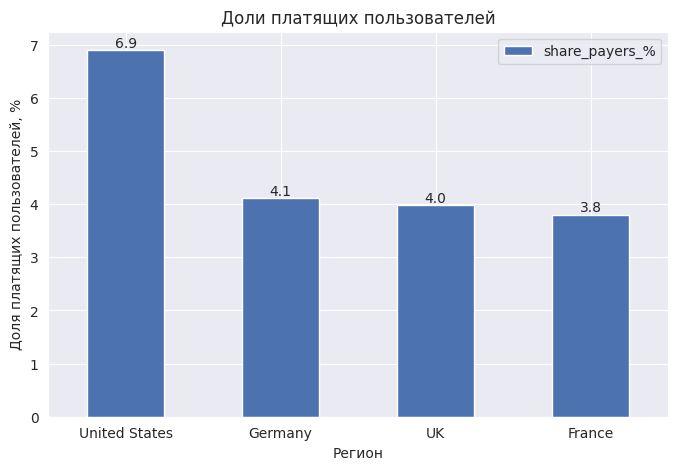

In [38]:
# зададим стиль и палитру графиков
sns.set_style('darkgrid')
sns.set_palette('deep')

# поcтроим столбчатую диаграмму
share_payers = user_region.drop(
    columns=['count_users', 'count_payers']).sort_values(
    'share_payers_%', ascending=False).plot(
    x='region',
    xlabel='Регион',
    ylabel='Доля платящих пользователей, %',
    title='Доли платящих пользователей',
    kind='bar',
    figsize=(8, 5),
    rot=0
);
for i in share_payers.patches:
    share_payers.annotate(
        np.round(i.get_height(), decimals=1),
        (i.get_x()+i.get_width()/2., i.get_height()),
        ha='center',
        va='bottom'
)

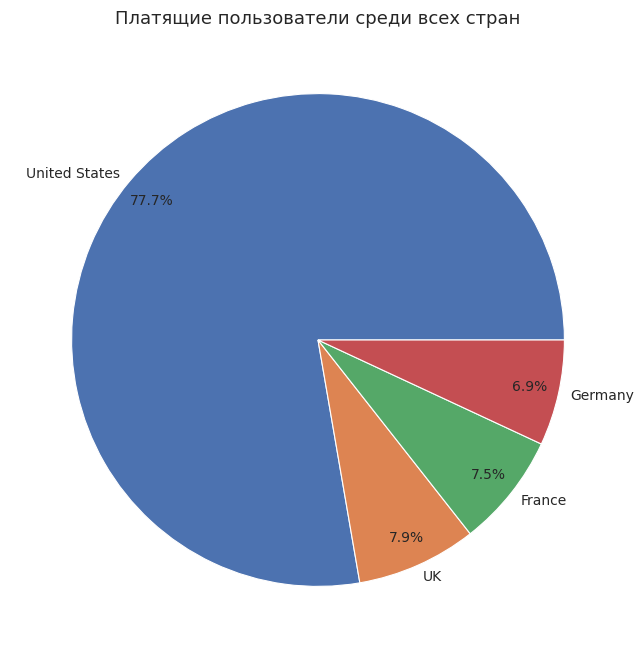

In [39]:
# построим круговую диаграмму
plt.rcParams["figure.figsize"] = (8, 8)
plt.title('Платящие пользователи среди всех стран', fontsize=13)
values = user_region['count_payers']
names = list(user_region['region'].unique())
plt.pie(
    values,
    labels=names,
    labeldistance=1.05,
    autopct='%1.1f%%',
    pctdistance=0.88,
    wedgeprops = {'linewidth': 0.8, 'edgecolor': 'white'}
);

#### **Вывод**

Пользователи приходят в приложение из четырёх стран: США, Великобритании, Франции и Германии. Больше всего платящих пользователей приходится на США — 6902, что составляет 77.7% из числа платящих пользователей всех стран. Доля платящих по отношению ко всем пользователям этой страны также находится на первом месте и равна 6.9%. Остальные страны находятся примерно на одном уровне, как по числу платящих пользователей, так и по их долям.

### Распределение пользователей по устройствам

Узнаем, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи.

In [40]:
# посмотрим распределение пользователей по устройствам
user_device = profiles.groupby('device').agg(
    {'user_id': 'count', 'payer': ['sum', 'mean']}
).reset_index()

# переименуем колонки
user_device.columns = ['device', 'count_users', 'count_payers', 'share_payers_%']

# для наглядности колонку с долей платящих пользователей умножим на 100
user_device['share_payers_%'] = user_device['share_payers_%'] * 100

# отсортируем датафрейм по числу платящих пользователей
user_device = (
    user_device.sort_values('count_payers', ascending=False).reset_index(drop=True)
)
# проверим результат
user_device

device  count_users  count_payers  share_payers_%
0   iPhone        54479          3382            6.21
1  Android        35032          2050            5.85
2      Mac        30042          1912            6.36
3       PC        30455          1537            5.05

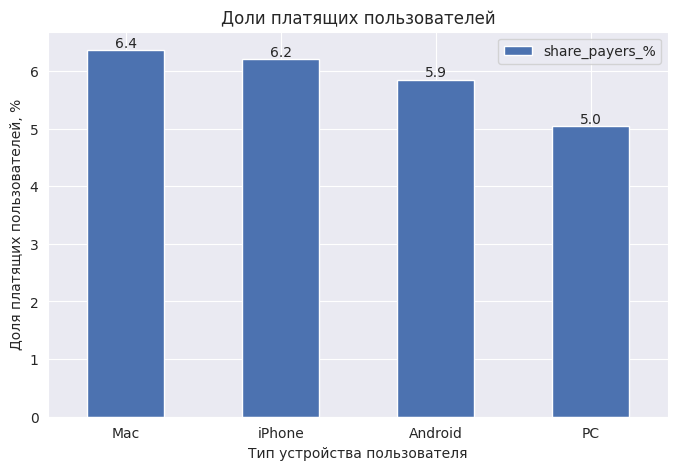

In [41]:
# поcтроим столбчатую диаграмму
share_payers = user_device.drop(
    columns=['count_users', 'count_payers']).sort_values(
    'share_payers_%', ascending=False).plot(
    x='device',
    xlabel='Тип устройства пользователя',
    ylabel='Доля платящих пользователей, %',
    title='Доли платящих пользователей',
    kind='bar',
    figsize=(8, 5),
    rot=0
);
for i in share_payers.patches:
    share_payers.annotate(
        np.round(i.get_height(), decimals=1),
        (i.get_x()+i.get_width()/2., i.get_height()),
        ha='center',
        va='bottom'
)

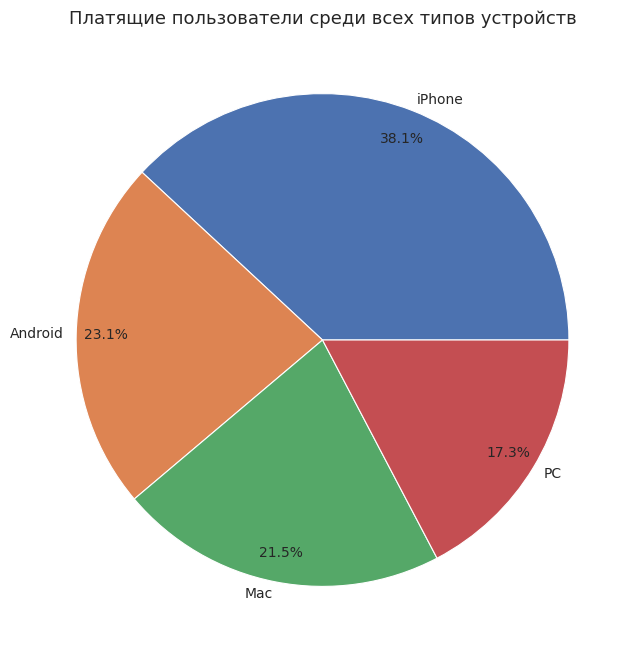

In [42]:
# построим круговую диаграмму
plt.rcParams["figure.figsize"] = (8, 8)
plt.title('Платящие пользователи среди всех типов устройств', fontsize=13)
values = user_device['count_payers']
names = list(user_device['device'].unique())
plt.pie(
    values,
    labels=names,
    labeldistance=1.05,
    autopct='%1.1f%%',
    pctdistance=0.88,
    wedgeprops = {'linewidth': 0.8, 'edgecolor': 'white'}
);

#### **Вывод**

Клиенты пользуются четырьмя устройствами: iPhone, Android, Mac, PC. Большинство платящих пользователей предпочитает iPhone — 3382, что составляет 38.1% из числа платящих пользователей всех стран. Доля платящих по отношению ко всем пользователям этого типа устройства также сопоставима с остальными типами устройств, Mac немного впереди с разницей в 0,2%. На последнем месте PC, как по числу платящих пользователей, так и по их долям.

### Распределение пользователей по рекламным источникам

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [43]:
# посмотрим распределение пользователей по рекламным источникам
user_channel = profiles.groupby('channel').agg(
    {'user_id': 'count', 'payer': ['sum', 'mean']}
).reset_index()

# переименуем колонки
user_channel.columns = ['channel', 'count_users', 'count_payers', 'share_payers_%']

# для наглядности колонку с долей платящих пользователей умножим на 100
user_channel['share_payers_%'] = user_channel['share_payers_%'] * 100

# отсортируем датафрейм по числу платящих пользователей
user_channel = (
    user_channel.sort_values('count_payers', ascending=False).reset_index(drop=True)
)
# проверим результат
user_channel

channel  count_users  count_payers  share_payers_%
0             FaceBoom        29144          3557           12.20
1               TipTop        19561          1878            9.60
2              organic        56439          1160            2.06
3       WahooNetBanner         8553           453            5.30
4           AdNonSense         3880           440           11.34
5       RocketSuperAds         4448           352            7.91
6              LeapBob         8553           262            3.06
7   OppleCreativeMedia         8605           233            2.71
8       lambdaMediaAds         2149           225           10.47
9              YRabbit         4312           165            3.83
10        MediaTornado         4364           156            3.57

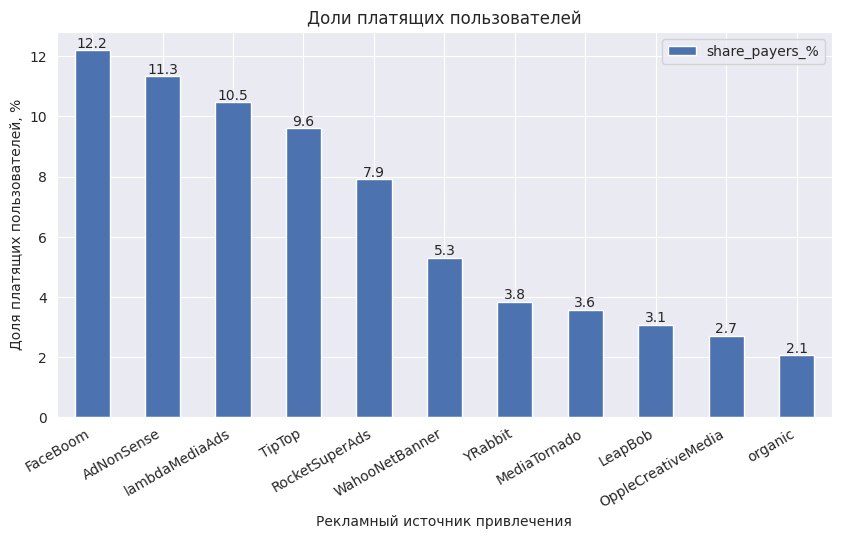

In [44]:
# поcтроим столбчатую диаграмму
share_payers = user_channel.drop(
    columns=['count_users', 'count_payers']).sort_values(
    'share_payers_%', ascending=False).plot(
    x='channel',
    xlabel='Рекламный источник привлечения',
    ylabel='Доля платящих пользователей, %',
    title='Доли платящих пользователей',
    kind='bar',
    figsize=(10, 5),
    rot=30
);
plt.xticks(ha='right')

for i in share_payers.patches:
    share_payers.annotate(
        np.round(i.get_height(), decimals=1),
        (i.get_x()+i.get_width()/2., i.get_height()),
        ha='center',
        va='bottom'
)

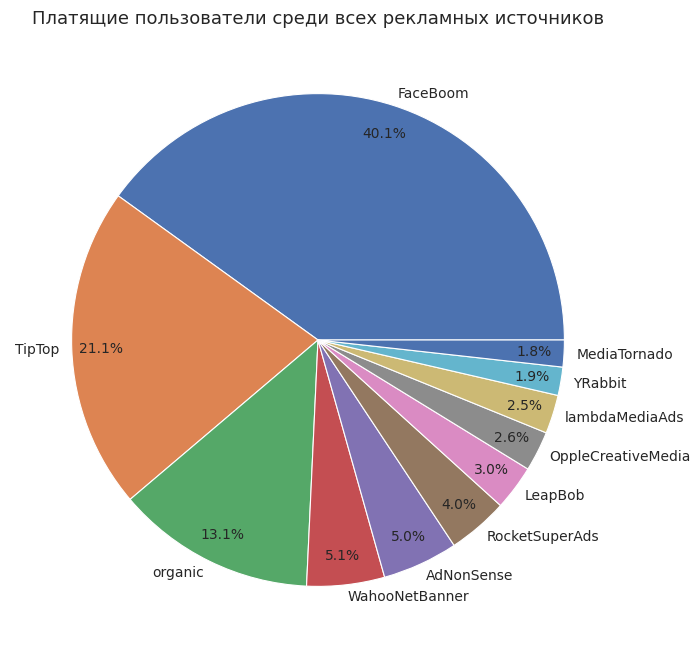

In [45]:
# построим круговую диаграмму
plt.rcParams["figure.figsize"] = (8, 8)
plt.title('Платящие пользователи среди всех рекламных источников', fontsize=13)
values = user_channel['count_payers']
names = list(user_channel['channel'].unique())
plt.pie(
    values,
    labels=names,
    labeldistance=1.05,
    autopct='%1.1f%%',
    pctdistance=0.88,
    wedgeprops = {'linewidth': 0.8, 'edgecolor': 'white'}
);

#### **Вывод**

Всего 11 рекламных источников. Наибольшее число платящих пользователей пришло из канала FaceBoom — 3557, что составляет 40.1% из числа платящих пользователей всех стран. Доля платящих по отношению ко всем пользователям этого источника также находится на первом месте и равна 12.2%.

Второе место занимает канал TipTop — 1878 платящих пользователей, что составляет 21.1% из числа платящих пользователей всех стран. Доля платящих пользователей по отношению ко всем пользователям этого источника равна 9.6%.

С помощью органического трафика пришло набольшее количество пользователей — 56439, из которых перешли в платящие 1160, что составляет 13.1% — третье место в рейтинге по количеству платящих пользователей всех стран, несмотря на низкие 2.1% в рейтинге долям.

Больше всего пользователей приходит из США, также они лучше других конвертируется. При этом большая часть пользователей заходит с мобильных устройств. Наибольшую конверсию имеют пользователи, которые пользуются Mac, а затем следуют пользователи iPhone, т.е. в целом пользователи Apple имеют лучшую конверсию в покупателей. Возможно, тут есть плюсы ApplePay.

## Маркетинг

### Общая сумма расходов на маркетинг, распределение по рекламным источникам

In [46]:
print(
    'Общая сумма расходов на маркетинг:',\
    round(profiles['acquisition_cost'].sum())
)

Общая сумма расходов на маркетинг: 105497


In [47]:
# посмотрим распределение расходов на маркетинг по рекламным источникам
cost_channel = profiles.groupby('channel').agg(
    {'acquisition_cost': 'sum'}).reset_index()

# переименуем колонки
cost_channel.columns = ['channel', 'total_cost']

# добавим колонку с долей расходов на маркетинг среди рекламных источников
cost_channel['share_total_cost_%'] = (
    cost_channel['total_cost'] / cost_channel['total_cost'].sum() * 100
)
# отсортируем датафрейм по расходам
cost_channel = (
    cost_channel.sort_values('total_cost', ascending=False).reset_index(drop=True)
)
# проверим результат
cost_channel

channel  total_cost  share_total_cost_%
0               TipTop    54751.30               51.90
1             FaceBoom    32445.60               30.75
2       WahooNetBanner     5151.00                4.88
3           AdNonSense     3911.25                3.71
4   OppleCreativeMedia     2151.25                2.04
5       RocketSuperAds     1833.00                1.74
6              LeapBob     1797.60                1.70
7       lambdaMediaAds     1557.60                1.48
8         MediaTornado      954.48                0.90
9              YRabbit      944.22                0.90
10             organic        0.00                0.00

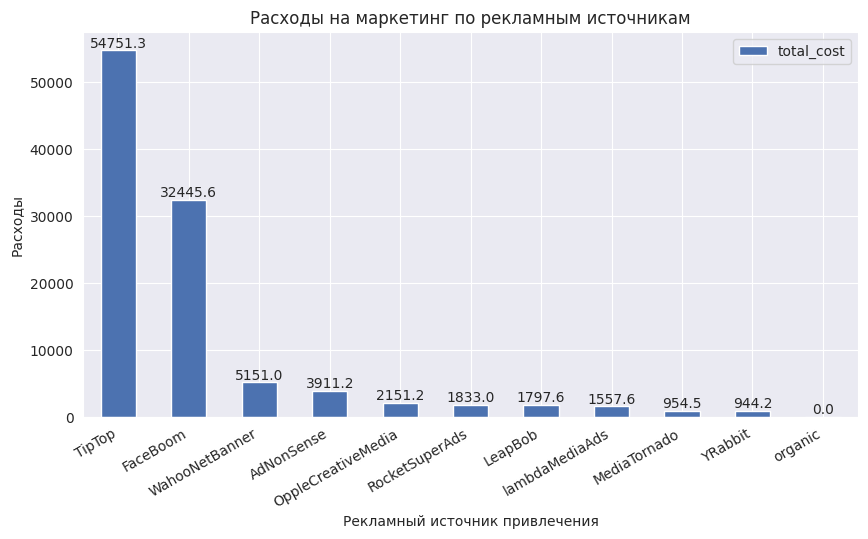

In [48]:
# поcтроим столбчатую диаграмму
cost_channel = cost_channel.drop(
    columns=['share_total_cost_%']).plot(
    x='channel',
    xlabel='Рекламный источник привлечения',
    ylabel='Расходы',
    title='Расходы на маркетинг по рекламным источникам',
    kind='bar',
    figsize=(10, 5),
    rot=30
);
plt.xticks(ha='right')

for i in cost_channel.patches:
    cost_channel.annotate(
        np.round(i.get_height(), decimals=1),
        (i.get_x()+i.get_width()/2., i.get_height()),
        ha='center',
        va='bottom'
)

#### **Вывод**

Мы выявили, что общая сумма расходов на маркетинг — 105497. Из которой 51.9% приходится на канал TipTop — 54751.3. Также существенные затраты идут на канал FaceBoom — 32445.6, доля составляет 30.8%. Расходы по каждому из оставшихся источников не превышают 5%. На привлечение органических пользователей траты нулевые.

###  Динамика изменения расходов во времени по каждому источнику

Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [49]:
# добавим колонку с порядковым номером недели
profiles['week'] = profiles['first_ts'].dt.isocalendar().week

# проверим результат
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  week  
0  2019-05-07 2019-05-01   True              1.09    19  
1  2019-07-09 2019-07-01  False              1.11    28  
2  2019-10-01 2019-10-01  False              0.00    40  
3  2019-08-22 2019-08-01  False              0.99    34  
4  2019-10-02 2019-10-01  False              0.23    40

In [50]:
# посмотрим расходы по месяцам по каждому источнику
cost_channel_month = profiles.pivot_table(
    index='month',
    columns='channel',
    values='acquisition_cost',
    aggfunc='sum'
)
cost_channel_month_t = cost_channel_month.T.reset_index()
cost_channel_month_t.columns =(
    ['channel', 'may', 'june', 'july', 'august', 'september', 'october']
)
# проверим результат
cost_channel_month_t

channel     may    june    july   august  september  october
0           AdNonSense 1169.70  538.65  504.00   579.60     581.70   537.60
1             FaceBoom 3524.40 5501.10 5294.30  6274.40    6114.90  5736.50
2              LeapBob  140.28  314.58  313.53   369.81     343.98   315.42
3         MediaTornado  238.56  138.00  138.48   154.56     144.72   140.16
4   OppleCreativeMedia  169.75  370.00  366.50   439.25     427.75   378.00
5       RocketSuperAds  577.98  325.72  252.07   253.11     218.40   205.72
6               TipTop 2981.00 6675.60 8410.20 11202.00   13232.50 12250.00
7       WahooNetBanner  418.80  921.00  851.40  1040.40     977.40   942.00
8              YRabbit  299.70  106.20   97.38   124.74     152.79   163.41
9       lambdaMediaAds  458.40  199.20  219.20   220.00     247.20   213.60
10             organic    0.00    0.00    0.00     0.00       0.00     0.00

In [51]:
# посмотрим расходы по неделям по каждому источнику
cost_channel_week = profiles.pivot_table(
    index='week',
    columns='channel',
    values='acquisition_cost',
    aggfunc='sum'
)
cost_channel_week_t = cost_channel_week.T.reset_index()

# проверим результат
cost_channel_week_t

week             channel     18     19     20     21      22      23      24  \
0             AdNonSense 211.05 273.00 265.65 266.70  202.65  102.90   96.60   
1               FaceBoom 535.70 750.20 755.70 722.70 1208.90 1081.30 1042.80   
2                LeapBob  16.80  31.71  26.67  26.67   65.52   66.99   52.29   
3           MediaTornado  38.64  61.68  59.04  50.16   36.96   27.60   29.76   
4     OppleCreativeMedia  24.00  34.50  27.50  34.25   81.75   79.50   71.50   
5         RocketSuperAds  99.45 139.23 138.06 131.04   97.70   76.05   63.18   
6                 TipTop 347.00 470.00 454.00 801.80 1421.20 1223.60 1121.00   
7         WahooNetBanner  49.20  92.40  90.00  79.20  179.40  196.80  166.20   
8                YRabbit  52.20  75.90  69.30  65.40   49.80   25.80   17.46   
9         lambdaMediaAds  81.60 103.20  90.40 119.20   83.20   35.20   45.60   
10               organic   0.00   0.00   0.00   0.00    0.00    0.00    0.00   

week      25      26  ...      34      35      36      37      38      39  \
0     141.75  148.05  ...  142.80  133.35  100.80  100.80  139.65  192.15   
1    1280.40 1647.80  ... 1411.30 1445.40 1151.70 1148.40 1496.00 1837.00   
2      68.46   99.75  ...   90.51   77.91   66.99   63.84   81.27  101.22   
3      32.16   40.56  ...   35.28   33.84   30.24   25.92   30.24   48.24   
4      79.75  107.00  ...  103.75   92.75   72.75   78.00  105.75  132.25   
5      80.73   78.26  ...   40.30   51.35   40.62   40.95   56.23   63.70   
6    1474.40 2343.60  ... 2514.00 2583.00 2563.00 2506.00 3241.00 3979.50   
7     201.60  285.00  ...  244.80  235.80  174.60  192.60  226.20  303.00   
8      22.14   27.90  ...   30.03   24.36   27.93   29.76   39.60   47.52   
9      40.00   59.20  ...   57.60   54.40   52.00   41.60   57.60   80.00   
10      0.00    0.00  ...    0.00    0.00    0.00    0.00    0.00    0.00   

week      40      41      42      43  
0     155.40  136.50  118.65  154.35  
1    1761.10 1392.60 1291.40 1552.10  
2     101.01   78.96   69.72   84.42  
3      42.00   36.96   29.04   37.44  
4     123.00   88.25   88.00  101.50  
5      66.30   51.68   46.48   50.70  
6    3703.00 3097.50 2737.00 3265.50  
7     309.00  208.80  216.00  253.20  
8      45.36   38.31   36.45   48.33  
9      59.20   60.80   47.20   53.60  
10      0.00    0.00    0.00    0.00  

[11 rows x 27 columns]

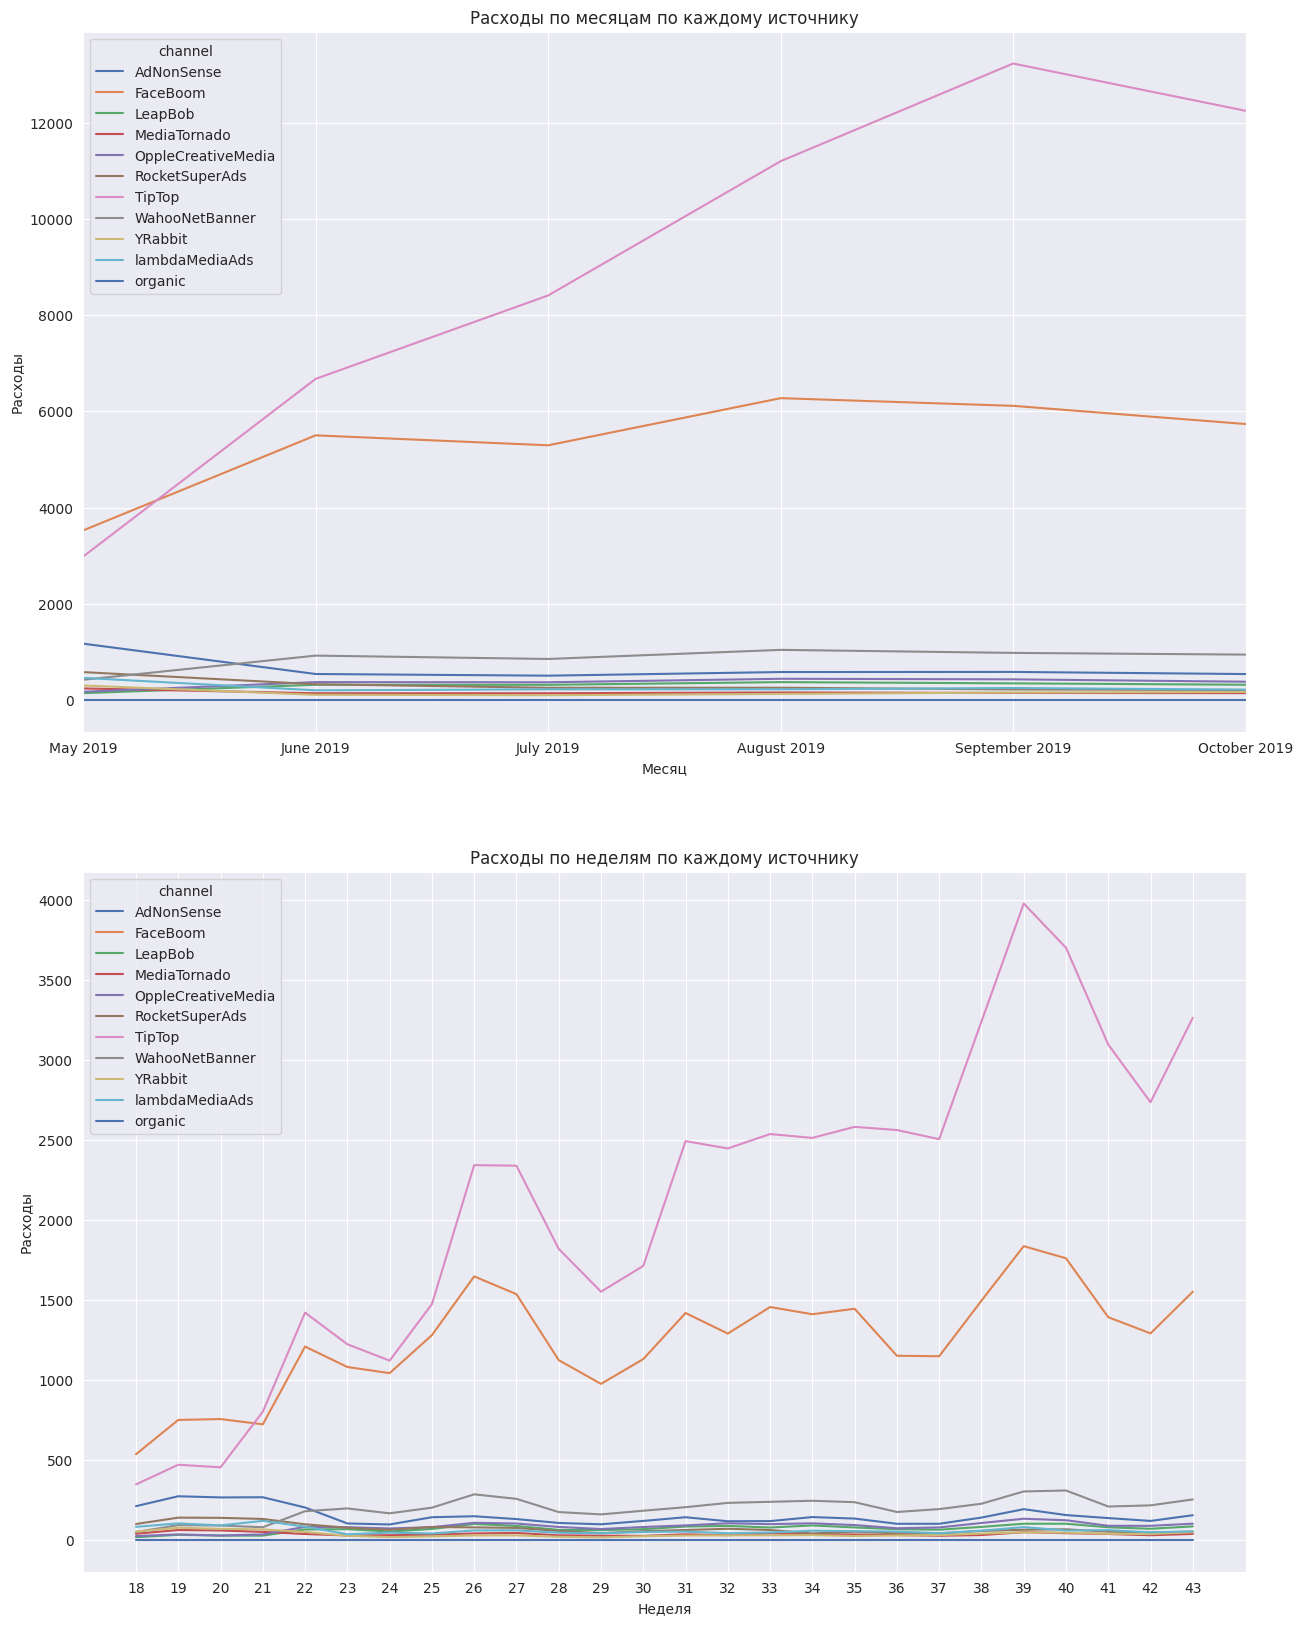

In [52]:
# зададим размер сетки для графиков
plt.figure(figsize=(15, 20))

# первый график — расходы по месяцам по каждому источнику
ax1 = plt.subplot(2, 1, 1)
cost_channel_month.plot(
    ax = ax1,
    grid=True,
    legend=True,
    xlabel='Месяц',
    ylabel='Расходы',
    title='Расходы по месяцам по каждому источнику'
)
ax1.set_xticks(
    [pandas_datetime.strftime("%B %Y") for pandas_datetime in cost_channel_month.index]
)
ax1.set_xticklabels(
    [pandas_datetime.strftime("%B %Y") for pandas_datetime in cost_channel_month.index]
)
# второй график — расходы по неделям по каждому источнику
ax2 = plt.subplot(2, 1, 2)
cost_channel_week.plot(
    ax=ax2,
    grid=True,
    legend=True,
    xlabel='Неделя',
    ylabel='Расходы',
    title='Расходы по неделям по каждому источнику',
    xticks=range(18, 44)
);

#### **Вывод**

Канал TipTop лидирует по расходам. Пик приходится на сентябрь, точнее на последнюю неделю месяца. В целом, расходы по этому каналу стремительно растут и с конца июля превышают 10000 в месяц. Второе место занимает канал FaceBoom. Затраты по нему растут более плавно и держатся на уровне 5000-6000 в месяц. Если смотреть на график с динамикой изменения по неделям, видно, что кривые обоих каналов схожи — пики и спады расходов происходят примерно в одни и те же недели. Затраты на остальные каналы без всплесков и практически на одном уровне — 100-1000 в месяц.

### Средняя стоимость привлечения одного пользователя (CAC) из каждого источника

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника.

In [53]:
# посчитаем средний CAC по каналам привлечения
cac_channel = profiles.pivot_table(
    index='channel',
    values='acquisition_cost',
    aggfunc='mean').sort_values(
    'acquisition_cost', ascending=False).reset_index()

# переименуем колонки
cac_channel.columns = ['channel', 'avg_cac']

# проверим результат
cac_channel

channel  avg_cac
0               TipTop     2.80
1             FaceBoom     1.11
2           AdNonSense     1.01
3       lambdaMediaAds     0.72
4       WahooNetBanner     0.60
5       RocketSuperAds     0.41
6   OppleCreativeMedia     0.25
7              YRabbit     0.22
8         MediaTornado     0.22
9              LeapBob     0.21
10             organic     0.00

In [54]:
# посмотрим описательную статистику, исключив органических пользователей
cac_channel.query('channel != "organic"').describe()

avg_cac
count    10.00
mean      0.76
std       0.79
min       0.21
25%       0.23
50%       0.51
75%       0.94
max       2.80

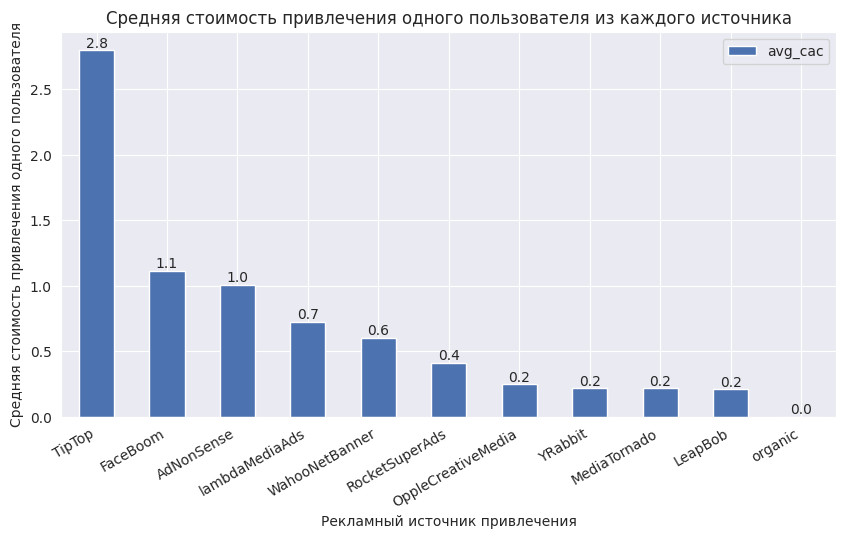

In [55]:
# поcтроим столбчатую диаграмму
cac_channel_vis = cac_channel.plot(
    x='channel',
    xlabel='Рекламный источник привлечения',
    ylabel='Средняя стоимость привлечения одного пользователя',
    title='Средняя стоимость привлечения одного пользователя из каждого источника',
    kind='bar',
    figsize=(10, 5),
    rot=30
);
plt.xticks(ha='right')

for i in cac_channel_vis.patches:
    cac_channel_vis.annotate(
        np.round(i.get_height(), decimals=1),
        (i.get_x()+i.get_width()/2., i.get_height()),
        ha='center',
        va='bottom'
)

#### **Вывод**

Наиболее дорогостоящим каналом привлечения пользователей является TipTop, однако количество и доля платящих пользователей, приходящих с этого источника, не так высоки. Это можно объяснить молодой аудиторией TipTop и, соответственно, их не очень высокой платежеспособностью. Затраты на привлечение органических пользователей нулевые.

## Оценим окупаемость рекламы

### Графики LTV и ROI, графики динамики LTV, CAC и ROI

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Затраты на привлечение органических пользователей нулевые, поэтому они всегда окупаются. А раз так, исключим их.

In [56]:
# удалим строки с органическими пользователями
profiles_filtered = profiles.query('channel != "organic"')

Установим момент и горизонт анализа данных. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [57]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

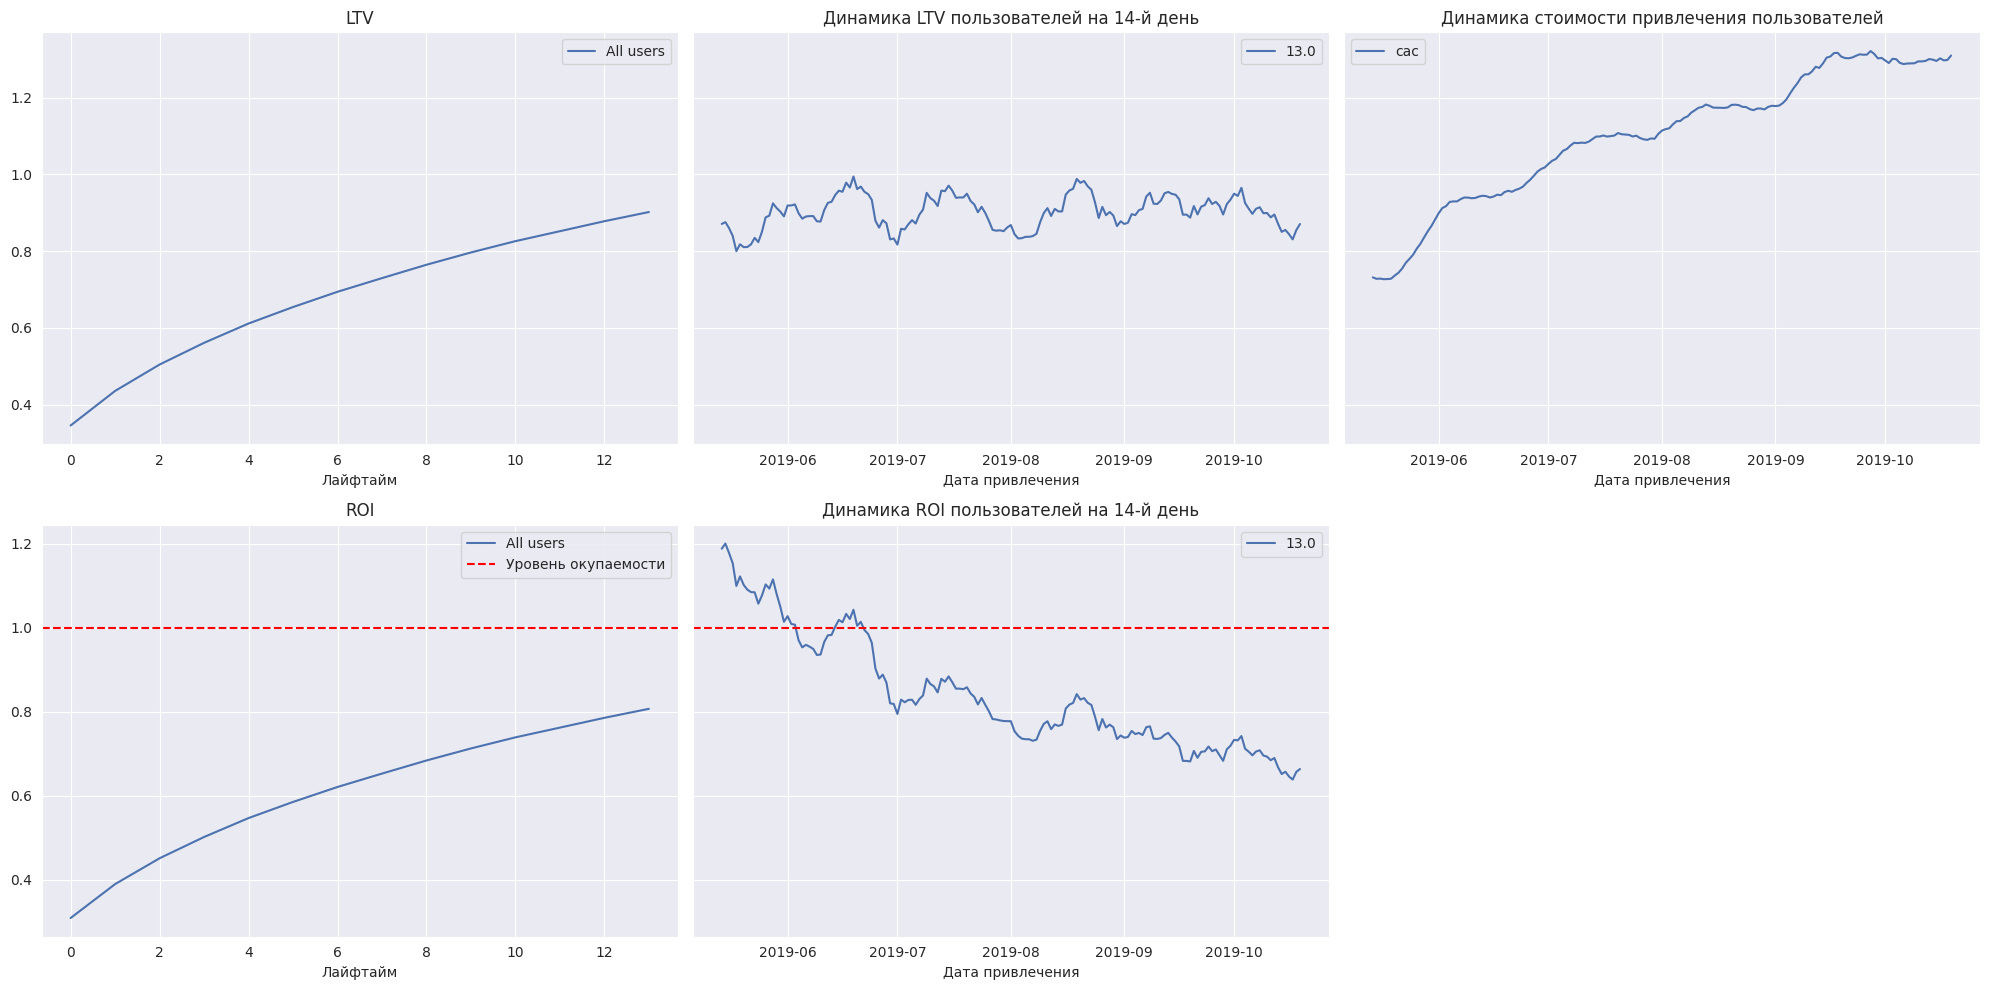

In [58]:
# посчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered,
    orders,
    observation_date,
    horizon_days
)
# построим графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

#### **Вывод**

- LTV («пожизненная ценность» клиента) выглядит реалистично — кривая плавно растёт от нуля и не снижается.
- CAC (стоимость привлечения одного клиента) с каждым месяцем стабильно растёт, т.е. рекламный бюджет только увеличивается.
- ROI (окупаемость инвестиций) в конце второй недели — в районе 80%. Реклама не окупается. В динамике этот показатель к октябрю снижается до 60-70%.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — устройству, стране и источнику первого посещения.

### Окупаемость рекламы с разбивкой по устройствам

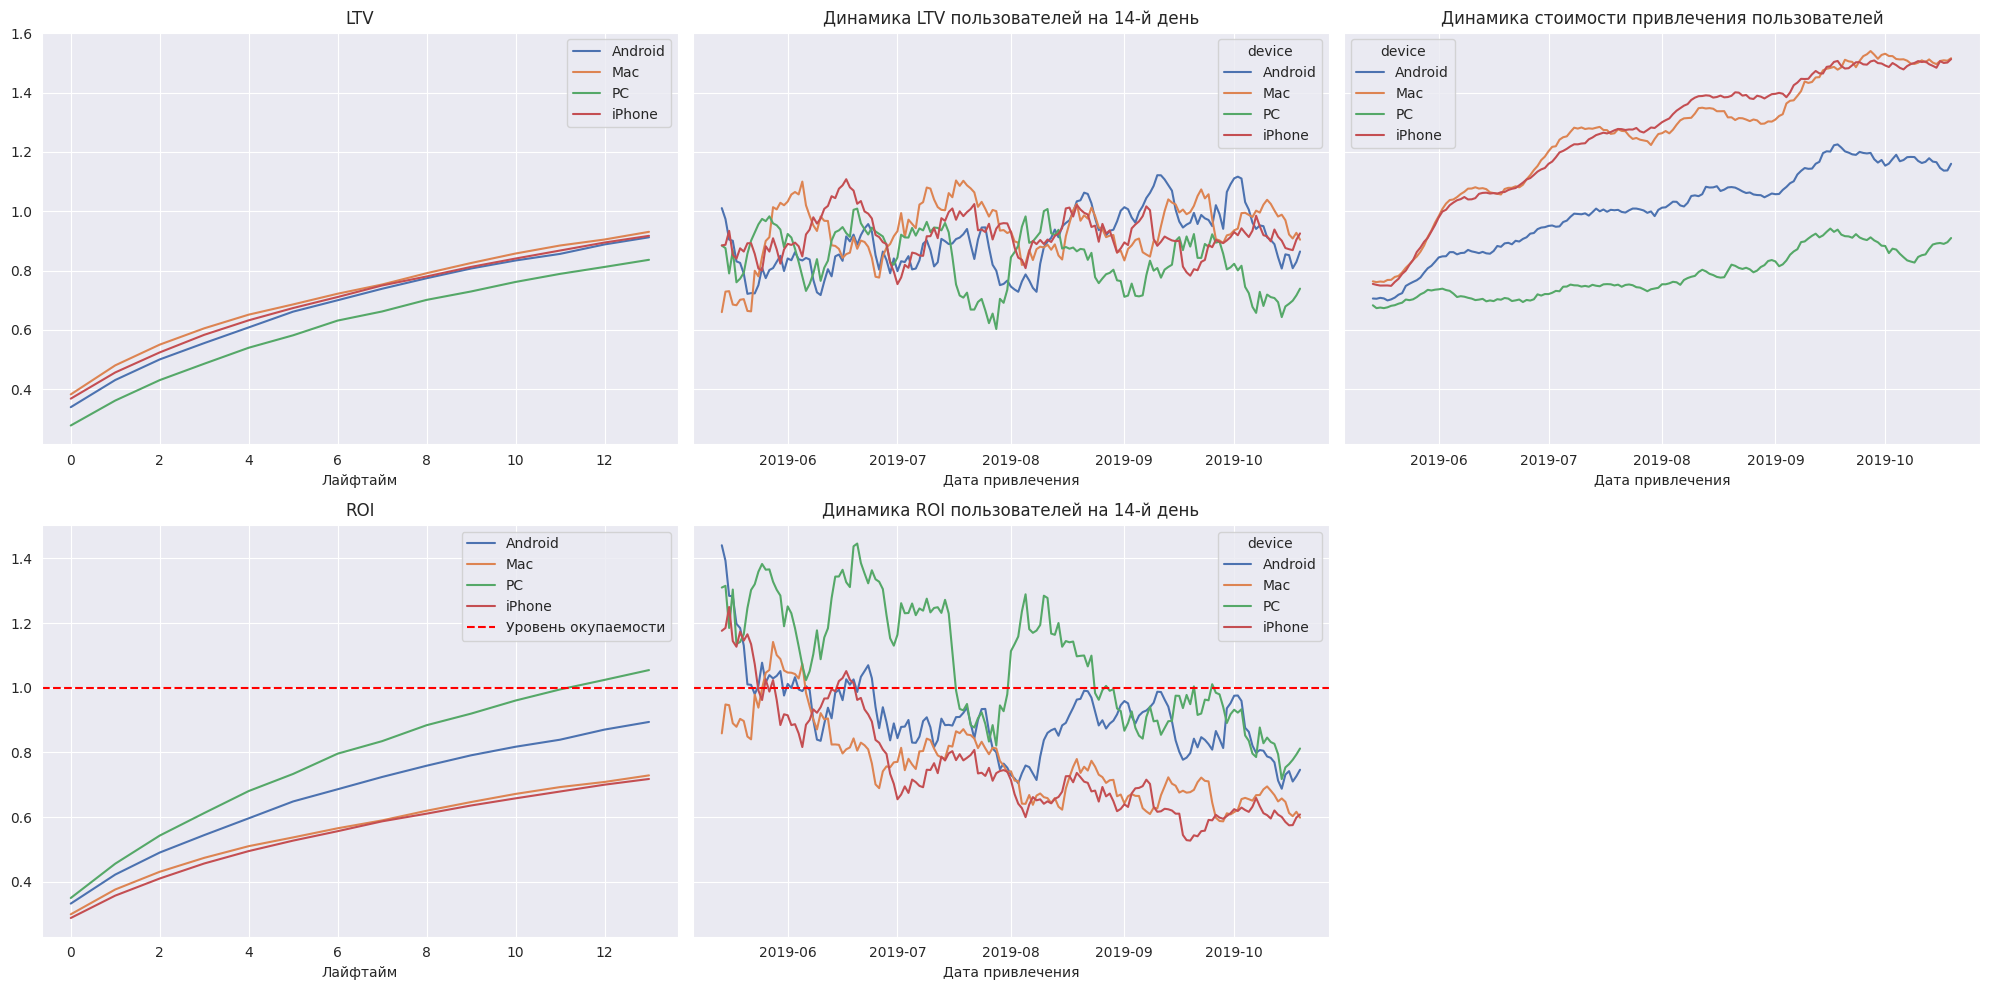

In [59]:
# передадим параметру dimensions колонку device
dimensions = ['device']

# посмотрим окупаемость с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
# построим графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

#### **Вывод**

- LTV («пожизненная ценность» клиента) выглядит реалистично для всех устройств — кривые плавно растут от нуля и не снижаются.
- По CAC (стоимость привлечения одного клиента) наблюдается тенденция роста по всем устройствам. Наибольшие показатели у iPhone и Mac, наименьшие у PC.
- Реклама окупается только по устройствам PC — ROI (окупаемость инвестиций) в районе 105%. Остальные устройства убыточны. По графику динамики видим, произошло падение окупаемости по PC в конце июля, а также начиная с сентября.

Проверим конверсию и удержание пользователей.

### Конверсия и удержание пользователей с разбивкой по устройствам

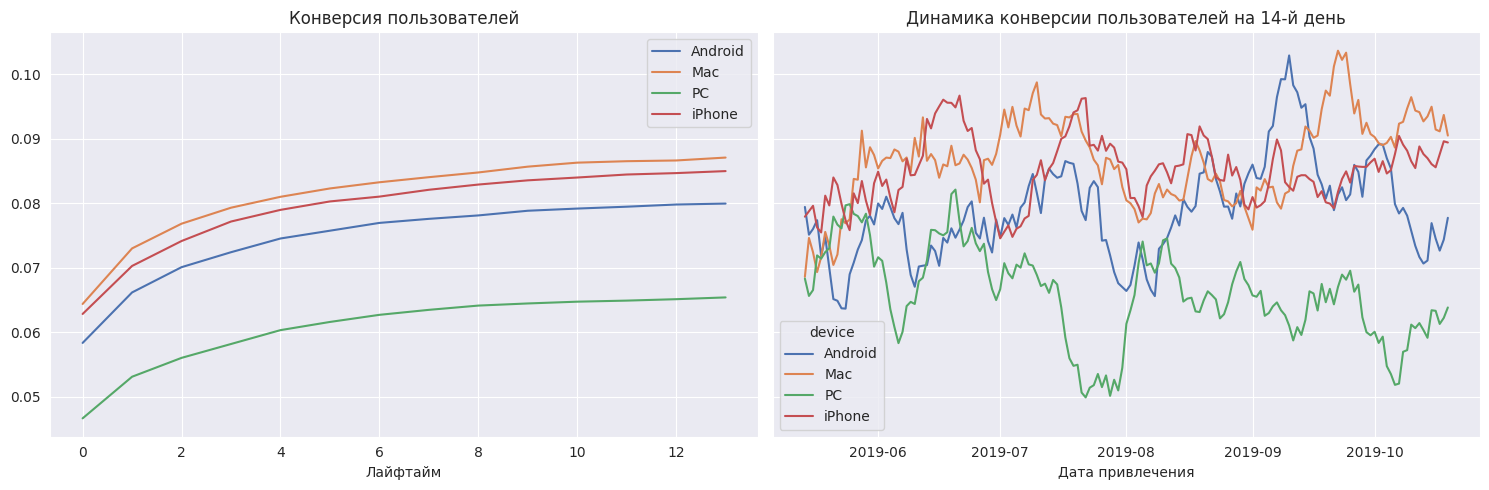

In [60]:
# передадим параметру dimensions колонку device
dimensions = ['device']

# посчитаем конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)
# построим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

#### **Вывод**

Видимо, причина не в конверсии. Кривая устройства PC ниже всех, однако только по нему есть окупаемость рекламы.

Посчитаем и визуализируем удержание пользователей.

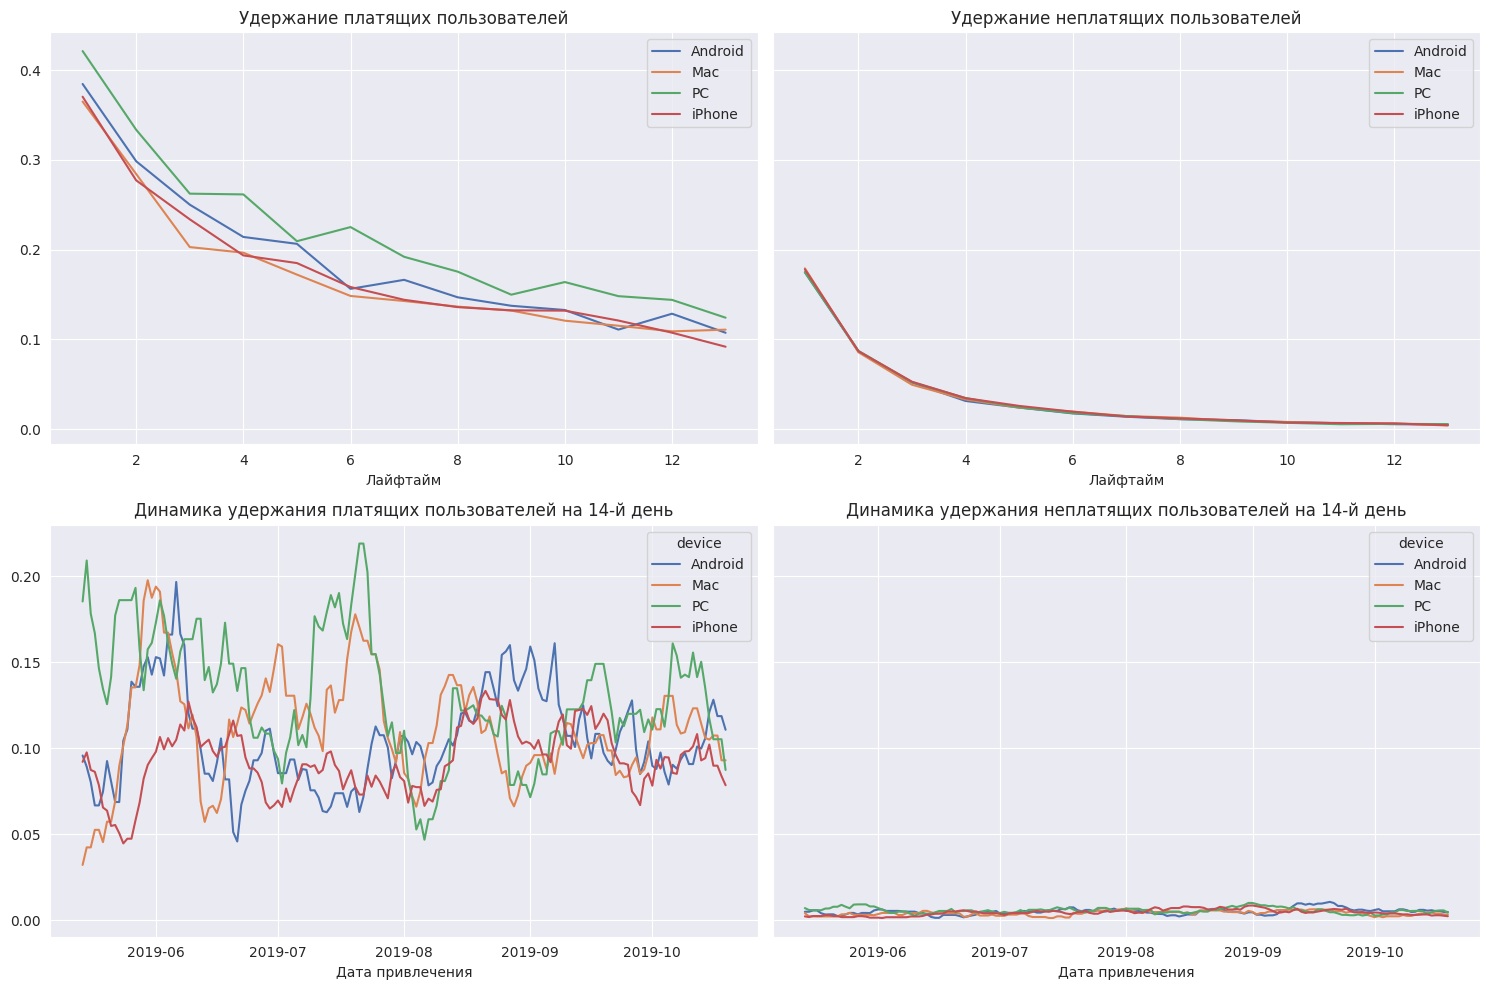

In [61]:
# передадим параметру dimensions колонку device
dimensions = ['device']

# посчитаем удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtered, visits, observation_date, horizon_days, dimensions=dimensions
)
# построим графики
plot_retention(retention_grouped, retention_history, horizon_days, window=14)

#### **Вывод**

Удержание платящих пользователей с устройствами PC выше остальных, хотя отрыв относительно небольшой. А в динамике по этому устройству и вовсе видим падение на начало июля, августа и сентября. К середине месяца ситуация выправляется, однако находится на уровне с остальными устройствами. Удержание неплатящих пользователей всех устройств очень схоже. Поэтому не будем утверждать, что причина именно в удержании.

Скорее всего, определяет окупаемость рекламы среди пользователей устройств PC именно низкая стоимость привлечения одного клиента по сравнению с другими устройствами.

### Окупаемость рекламы с разбивкой по странам

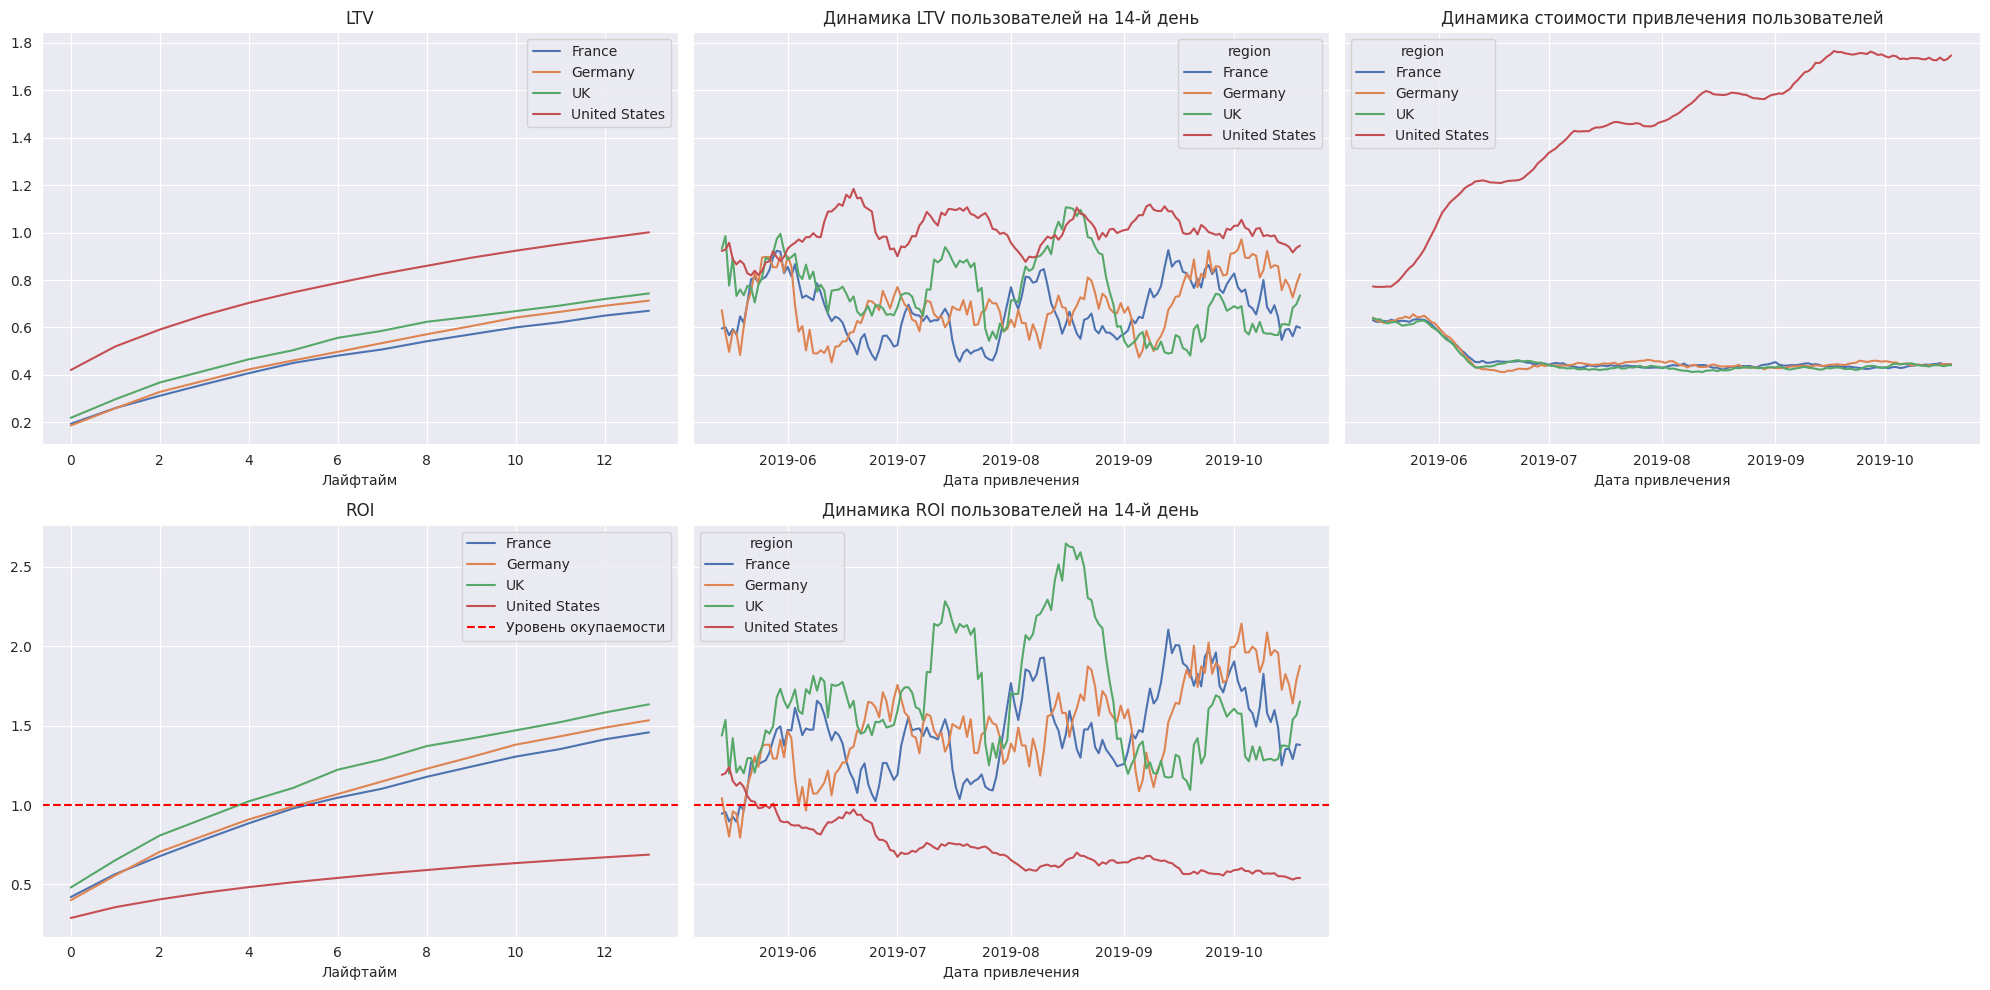

In [62]:
# передадим параметру dimensions колонку region
dimensions = ['region']

# посмотрим окупаемость с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
# построим графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

#### **Вывод**

- LTV («пожизненная ценность» клиента) выглядит реалистично для всех стран — кривые плавно растут от нуля и не снижаются.
- CAC (стоимость привлечения одного клиента) с каждым месяцем растёт только в США. В остальных странах рекламный бюджет стабилен и находится примерно на одном уровне.
- Реклама не окупается только в США — в конце второй недели ROI (окупаемость инвестиций) не превышает 70%. Скорее всего, именно из-за высокого рекламного бюджета. В остальных странах реклама окупается. В Великобритании немного лучше и раньше остальных — с пятого дня, в Германии и Франции — с шестого. По графику динамики видим, что пик окупаемости был в Великобритании в августе.

Проверим конверсию и удержание пользователей.

### Конверсия и удержание пользователей с разбивкой по странам

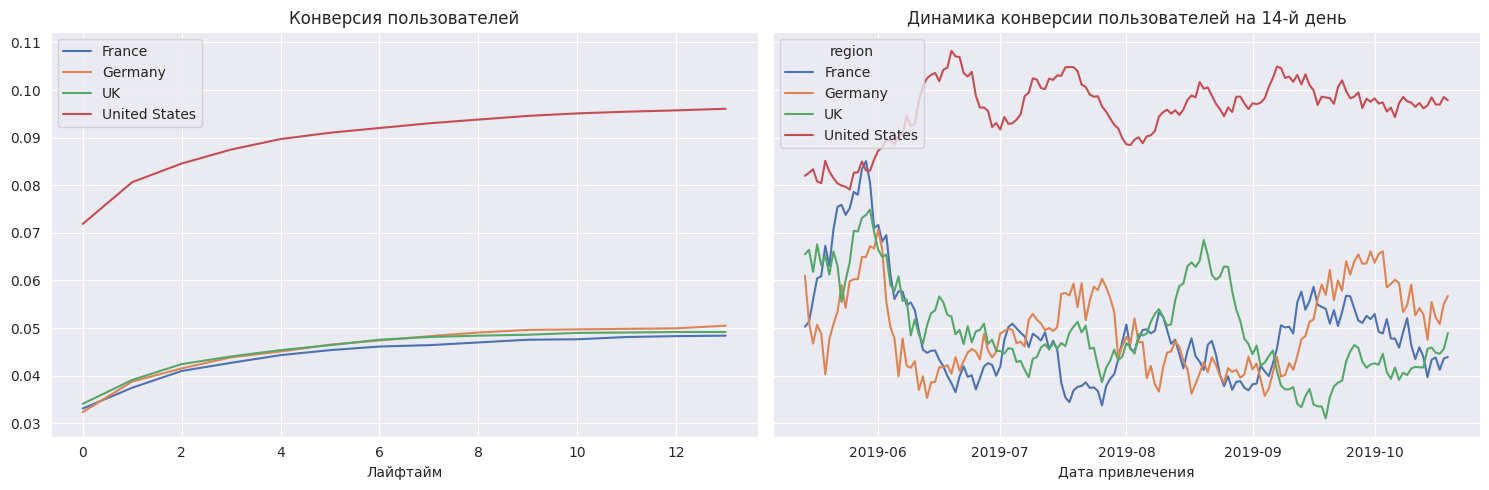

In [63]:
# передадим параметру dimensions колонку region
dimensions = ['region']

# посчитаем конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)
# построим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

#### **Вывод**

Причина убыточности рекламы в США явно не в конверсии, так как пользователи именно этой страны конвертируются лучше других. Конверсия пользователей остальных стран схожа.

Посчитаем и визуализируем удержание пользователей.

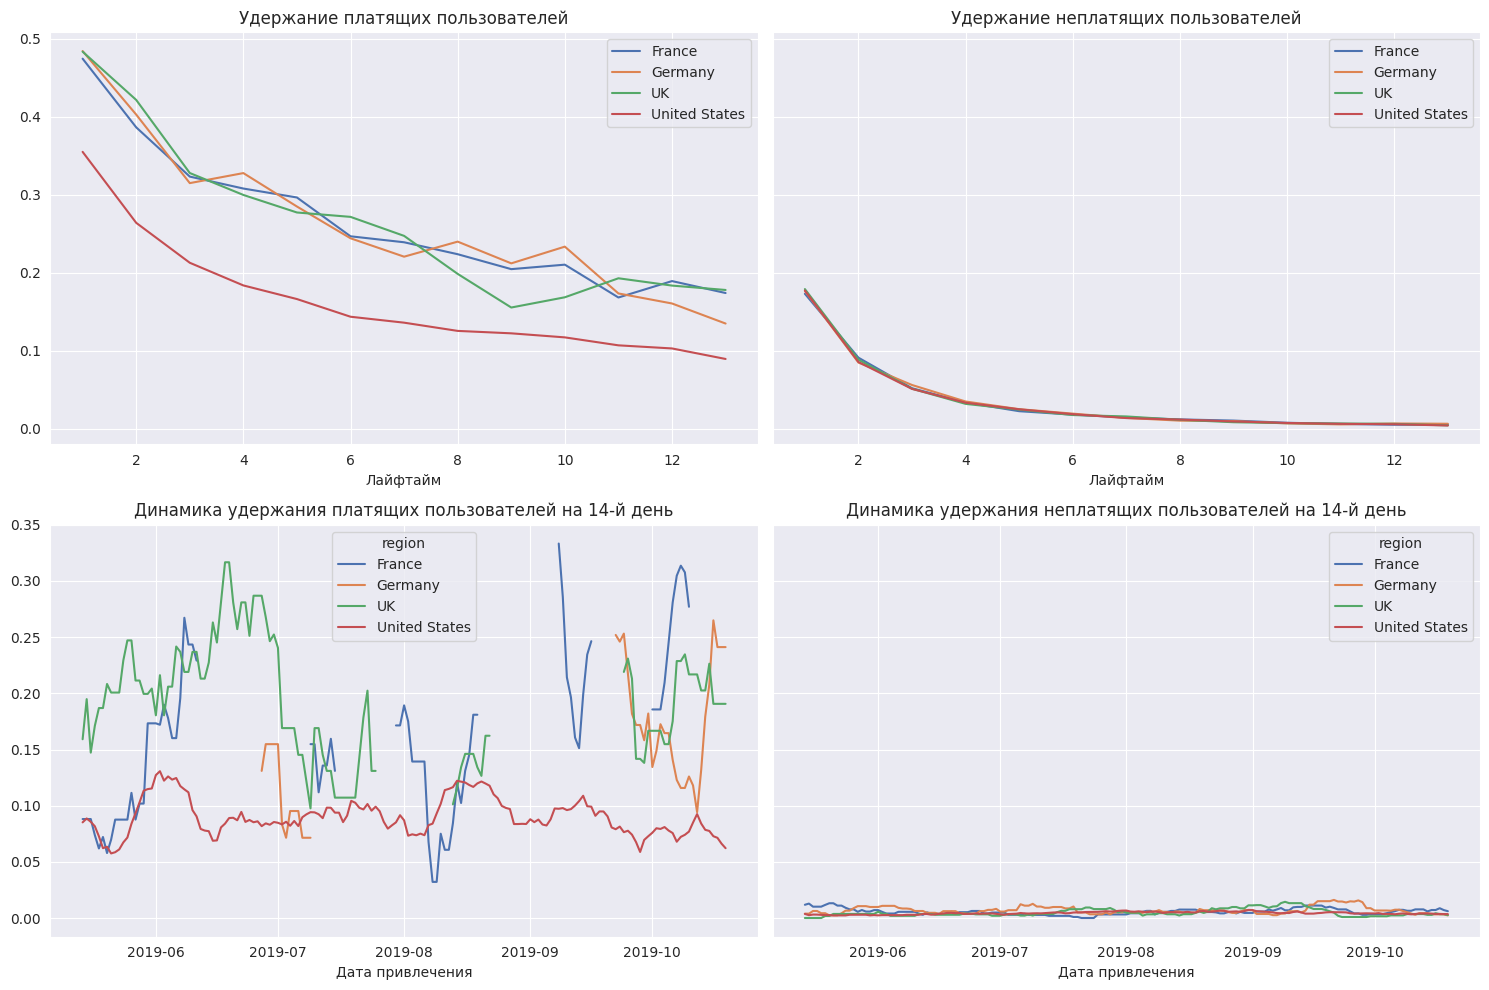

In [64]:
# передадим параметру dimensions колонку region
dimensions = ['region']

# посчитаем удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtered, visits, observation_date, horizon_days, dimensions=dimensions
)
# построим графики
plot_retention(retention_grouped, retention_history, horizon_days, window=14)

#### **Вывод**

Скорее всего, причина убыточности рекламы в США как раз в удержании платящих пользователей — кривая заметно ниже остальных, что также прослеживается и в динамике. Вероятно, это связано с какой-нибудь технической проблемой. Обычно такая информация хранится в данных о дополнительных событиях, в дальнейшем можно запросить необходимые данные и проверить эту гипотезу.

Стоит обратить внимание на график динамики удержания платящих пользователей на 14-й день — прерывающиеся кривые по Великобритании, Франции и Германии. Возможно, нам не хватает данных по этим странам, или пропуски в кривой — это органические пользователи, которых мы исключили из анализа окупаемости рекламы. 

### Окупаемость рекламы с разбивкой по рекламным каналам

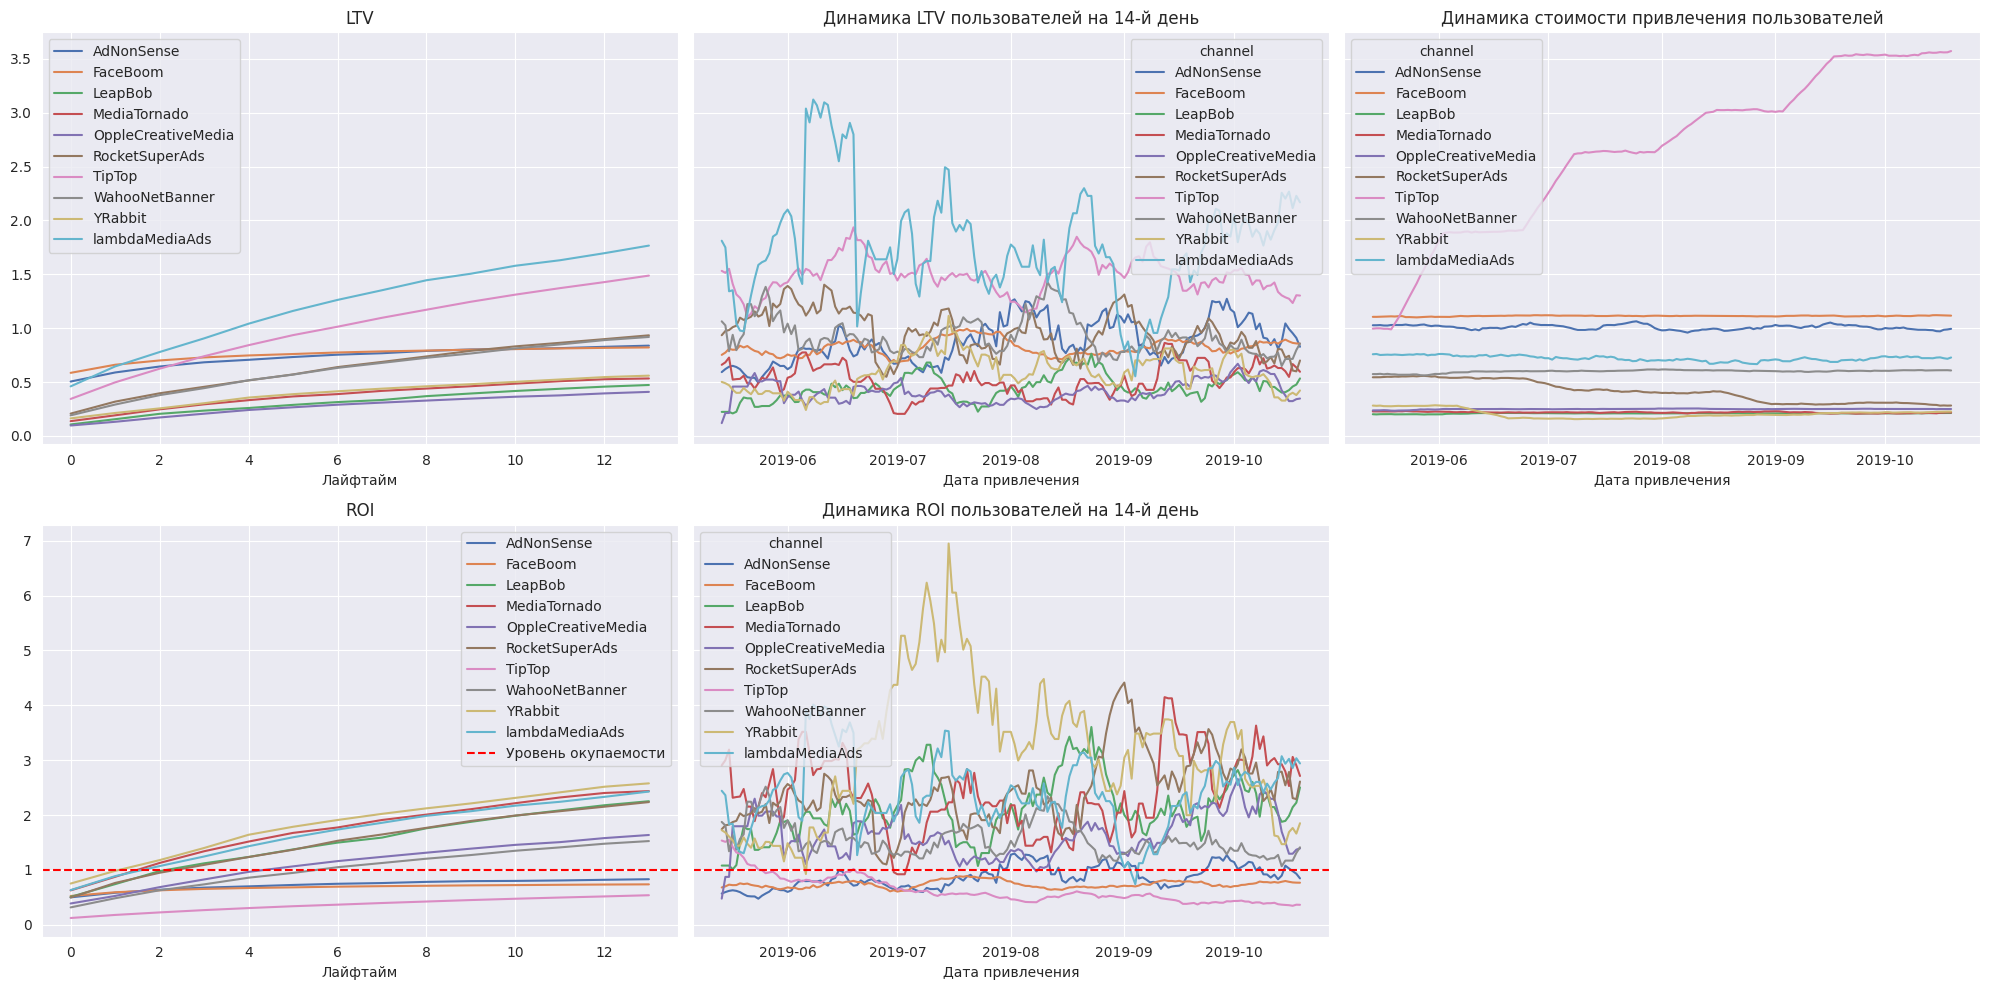

In [65]:
# передадим параметру dimensions колонку channel
dimensions = ['channel']

# посмотрим окупаемость с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
# построим графики
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

In [66]:
# посмотрим топ-5 каналов с наименьшей стоимостью привлечения одного клиента
top_cac = (
    cac_channel.query('channel != "organic"')\
    .sort_values('avg_cac').reset_index(drop=True).head()
)
# проверим результат
top_cac

channel  avg_cac
0             LeapBob     0.21
1        MediaTornado     0.22
2             YRabbit     0.22
3  OppleCreativeMedia     0.25
4      RocketSuperAds     0.41

In [67]:
# создадим список из этих каналов
top_cac_list = list(top_cac['channel'])

# проверим результат
top_cac_list

['LeapBob', 'MediaTornado', 'YRabbit', 'OppleCreativeMedia', 'RocketSuperAds']

In [68]:
# посмотрим топ-5 каналов с наибольшей окупаемостью
top_roi = roi_grouped.sort_values(13.0, ascending=False).reset_index().head()

# проверим результат
top_roi

channel  cohort_size  cac  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  \
0         YRabbit         4102 0.22 0.75 0.98 1.18 1.40 1.64 1.79 1.91 2.02   
1    MediaTornado         4167 0.22 0.63 0.87 1.13 1.34 1.52 1.68 1.77 1.91   
2  lambdaMediaAds         2056 0.73 0.63 0.89 1.07 1.25 1.43 1.60 1.74 1.86   
3         LeapBob         8103 0.21 0.51 0.74 0.98 1.12 1.24 1.37 1.50 1.59   
4  RocketSuperAds         4251 0.42 0.50 0.76 0.95 1.09 1.24 1.37 1.53 1.65   

   8.0  9.0  10.0  11.0  12.0  13.0  
0 2.12 2.21  2.31  2.41  2.52  2.58  
1 2.01 2.11  2.22  2.32  2.40  2.44  
2 1.99 2.07  2.17  2.24  2.33  2.43  
3 1.76 1.88  1.99  2.09  2.18  2.25  
4 1.77 1.89  1.99  2.07  2.15  2.24

In [69]:
# cоздадим топ каналов, которые есть в обоих списках
top_roi_cac =  top_roi[top_roi['channel'].isin(top_cac_list)]
list(top_roi_cac['channel'])

['YRabbit', 'MediaTornado', 'LeapBob', 'RocketSuperAds']

#### **Вывод**

- LTV («пожизненная ценность» клиента) выглядит реалистично для всех рекламных каналов — кривые плавно растут от нуля и не снижаются.
- CAC (стоимость привлечения одного клиента) с каждым месяцем растёт только в Tip Top. В остальных каналах рекламный бюджет стабилен.
- Реклама не окупается в каналах Tip Top, FaceBoom и AdNonSense — ROI (окупаемость инвестиций) не доходит до 100%. По остальным каналам реклама окупается, а в некоторых даже достигает к концу второй недели 250%. По графику динамики видим, пик окупаемости был по каналу YRabbit в июле, однако к осени окупаемость по нему снизилась и выровнялась с остальными каналами.

  Резюмируя, наиболее перспективные каналы: YRabbit, MediaTornado, LeapBob и RocketSuperAds. По ним ROI наибольшая, а CAC наименьшая.

Проверим конверсию и удержание пользователей.

### Конверсия и удержание пользователей с разбивкой по рекламным каналам

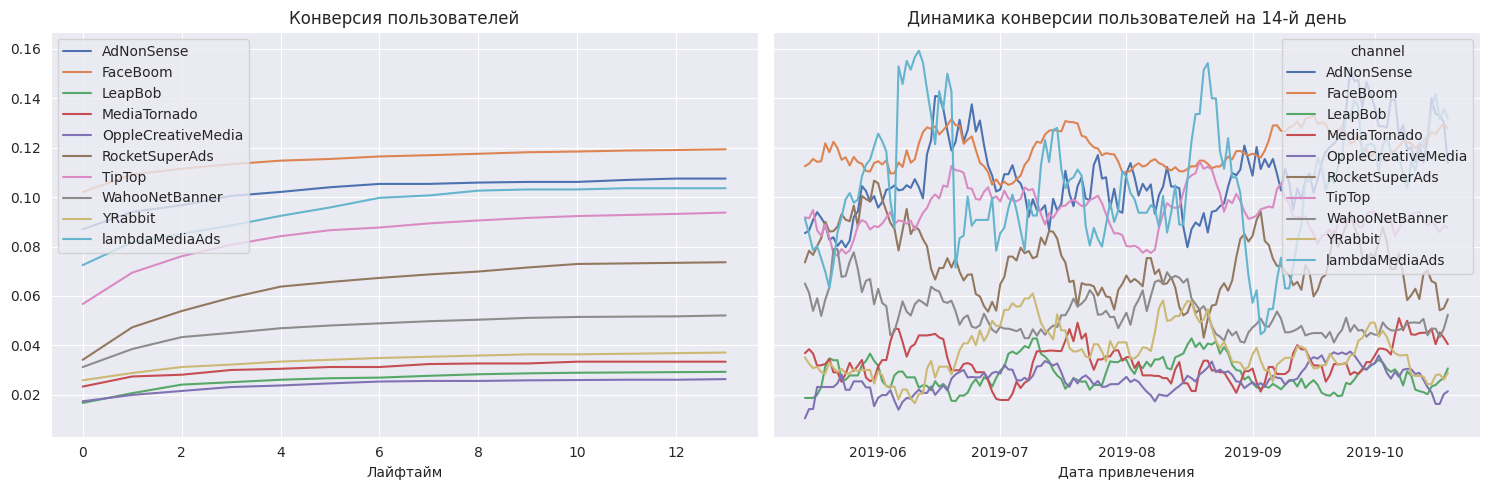

In [70]:
# передадим параметру dimensions колонку channel
dimensions = ['channel']

# посчитаем конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)
# построим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14)

#### **Вывод**

Причина убыточности рекламы в каналах Tip Top, FaceBoom и AdNonSense явно не в конверсии, так как пользователи именно из этих каналов конвертируются лучше других.

Посчитаем и визуализируем удержание пользователей.

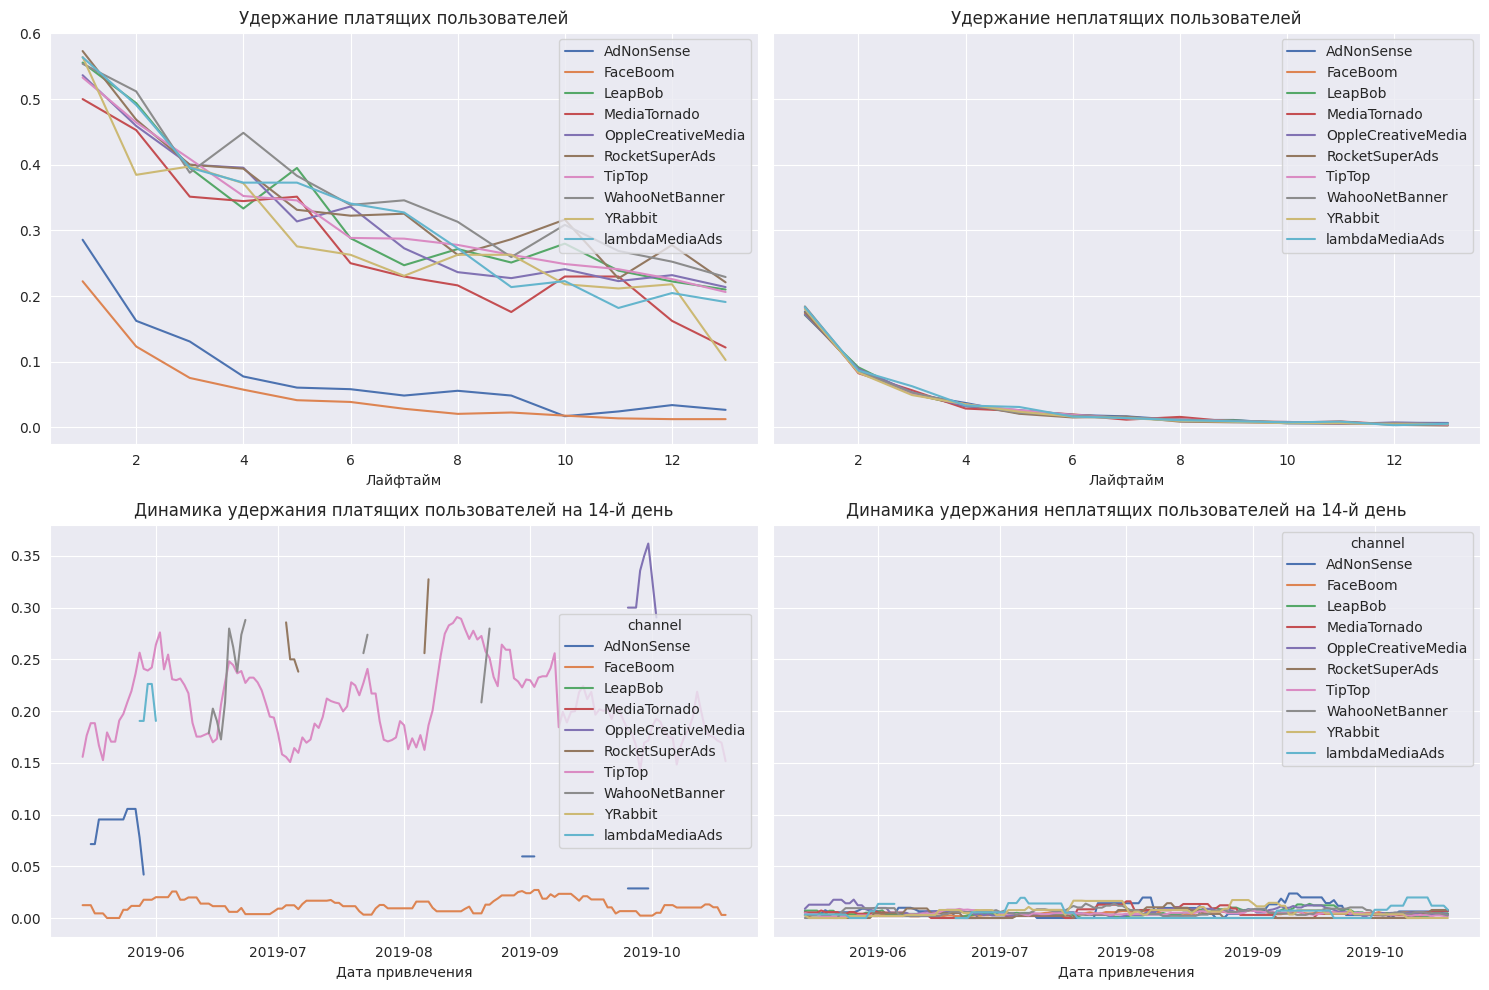

In [71]:
# передадим параметру dimensions колонку channel
dimensions = ['channel']

# посчитаем удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filtered, visits, observation_date, horizon_days, dimensions=dimensions
)
# построим графики
plot_retention(retention_grouped, retention_history, horizon_days, window=14)

#### **Вывод**

Действительно, причина убыточности рекламы в каналах FaceBoom и AdNonSense как раз в удержании платящих пользователей — кривые заметно ниже остальных, что также прослеживается и в динамике. Вероятно, это связано с какой-нибудь технической проблемой. Обычно такая информация хранится в данных о дополнительных событиях, в дальнейшем можно запросить необходимые данные и проверить эту гипотезу.

Что касается канала Tip Top, причина убыточности рекламы не связана с удержанием, как и с конверсией. Скорее всего, источник не окупается именно из-за высокой стоимости привлечения одного клиента по сравнению с другими каналами.

Стоит снова обратить внимание на график динамики удержания платящих пользователей на 14-й день — прерывающиеся кривые по всем каналам, кроме Tip Top и FaceBoom. Возможно, нам не хватает данных по этим источникам.

## Выводы

В ходе анализа мы изучили и обработали данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года, а также разобрались в причинах убытков последних нескольких месяцев. В целом реклама, направленная на привлечение пользователей, не окупается — к октябрю ROI снижается до 60-70%, а общий рекламный бюджет на протяжении всего времени только увеличивается. Выделим возможные причины. 


1. Всего 11 рекламных источников. Реклама не окупается в трёх:

- Tip Top. Вероятно, убыточность связана с высокой стоимостью привлечения одного клиента, которая с мая по октябрь стабильно увеличивается. По этому источнику наибольшие расходы на маркетинг — 54751.3, что составляет 51.9% из всего рекламного бюджета.
- FaceBoom и AdNonSense. Причина в плохом удержании платящих пользователей. Наибольшее число платящих пользователей пришло как раз из канала FaceBoom — 3557, что составляет 40.1%, поэтому стоит внимательнее изучить источник возникновения проблемы. Также по FaceBoom существенные расходы на маркетинг — 32445.6, что составляет 30.8% из всего рекламного бюджета.

    Таким образом, общая сумма расходов на маркетинг — 105497, из которых 82,7% идут на источники, реклама по которым не окупается.

    **Рекомендация.** Необходимо проверить связано ли плохое удержание платящих пользователей в FaceBoom и AdNonSense с какой-нибудь технической проблемой. Если при проверке никаких проблем не обнаружится, то стоит направить рекламный бюджет в другие источники. Топ перспективных каналов: YRabbit, MediaTornado, LeapBob, RocketSuperAds. У них наименьшая стоимость привлечения одного клиента, а окупаемость рекламы выше остальных и достигает к концу второй недели 220-250%.
   

2. Пользователи приходят в приложение из четырёх стран: США, Великобритании, Франции и Германии. Больше всего платящих пользователей приходится на США — 6902, что составляет 77.7% из числа платящих пользователей всех стран. И в то же время только в США реклама убыточна — в конце второй недели ROI не превышает 70%. Скорее всего, это связано с высокой стоимостью привлечения одного клиента и плохом удержании платящих пользователей.

    **Рекомендация.** Необходимо проверить связано ли плохое удержание платящих пользователей в США с какой-нибудь технической проблемой.
    

3. Клиенты пользуются четырьмя устройствами: iPhone, Android, Mac, PC.  Негативное влияние на окупаемость рекламы оказывают устройства iPhone, Mac — к концу второй недели ROI не превышает 75%, а также Android — ROI не превышает 90%.

    **Рекомендация.** Возможно, стоит задуматься о перераспределении рекламного бюджета в пользу PC. Но для начала стоит проверить вышеперечисленные рекомендации, так как большинство платящих пользователей именно на устройствах с убыточной рекламой.